# ATOC 4500 Project: Cluster Analysis of Colorado Seasons
Authors: Sydney Crandall (sycr6025@colorado.edu) and Alyssa Ripley

Last Updated: April 12th, 2022 at 1:25pm

This code is available at github at **Insert URL here**

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans, whiten
import datetime

In [4]:
# read in data
limonDF = pd.read_csv("Limon_2012-2021_hourlydata_munged.csv")
grandJunctionOrigDF = pd.read_csv("72476023066_GrandJunction_2002-2021_hourlydata_munged.csv")
boulderDF = pd.read_csv("72053300160_Boulder_2012-2021_hourlydata_munged.csv")
eagleDF = pd.read_csv("72467523063_Eagle_2012-2021_hourlydata_munged.csv")

In [6]:
# add columns for day, month, year, hour, and minute
limonDF["datetime"] = pd.to_datetime(limonDF["datetime"])
limonDF["year"] = limonDF["datetime"].dt.year
limonDF["month"] = limonDF['datetime'].dt.month
limonDF["day"] = limonDF['datetime'].dt.day
limonDF["hour"] = limonDF["datetime"].dt.hour

boulderDF["datetime"] = pd.to_datetime(boulderDF["datetime"])
boulderDF["year"] = boulderDF["datetime"].dt.year
boulderDF["month"] = boulderDF['datetime'].dt.month
boulderDF["day"] = boulderDF['datetime'].dt.day
boulderDF["hour"] = boulderDF['datetime'].dt.hour
boulderDF["minute"] = boulderDF["datetime"].dt.minute

eagleDF["datetime"] = pd.to_datetime(eagleDF["datetime"])
eagleDF["year"] = eagleDF["datetime"].dt.year
eagleDF['month'] = eagleDF['datetime'].dt.month
eagleDF["day"] = eagleDF['datetime'].dt.day
eagleDF['hour'] = eagleDF['datetime'].dt.hour

grandJunctionOrigDF["datetime"] = pd.to_datetime(grandJunctionOrigDF["datetime"])
grandJunctionOrigDF["year"] = grandJunctionOrigDF["datetime"].dt.year
grandJunctionOrigDF["month"] = grandJunctionOrigDF['datetime'].dt.month
grandJunctionOrigDF["day"] = grandJunctionOrigDF['datetime'].dt.day
grandJunctionOrigDF['hour'] = grandJunctionOrigDF["datetime"].dt.hour

In [7]:
# look at Boulder Dataframe
# bouder has 3x as much data as the other datasets, so we will only keep data that is recorded in the first 30 minutes
# of the hour
boulderMungedDF = boulderDF.query("minute < 30")
boulderMungedDF = boulderMungedDF.reset_index()
boulderDF = boulderMungedDF

In [8]:
# find the row number closest to the start of the other datasets
grandJunctionOrigDF.loc[128691] # this is the closest to the start of the other datasets
 
# create a new dataframe for new time period ( from the closest to the start of the other datasets to the end)
grandJunctionDF = grandJunctionOrigDF[128692:]
grandJunctionDF.index = range(len(grandJunctionDF)) # adjust the row indices to start at 0
#grandJunctionDF.head(10)

In [9]:
# add columns for season
# from Homework 4
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

# function for relating season to month
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k] 
        
limonDF['season']= [season(month) for month in pd.DatetimeIndex(limonDF['datetime']).month]
boulderDF['season']=[season(month) for month in pd.DatetimeIndex(boulderDF['datetime']).month]
eagleDF['season']=[season(month) for month in pd.DatetimeIndex(eagleDF['datetime']).month]
grandJunctionDF['season']=[season(month) for month in pd.DatetimeIndex(grandJunctionDF['datetime']).month]

# check one of the datasets to make sure it worked
#limonDF.query("season == 3")

C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/4020685223.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandJunctionDF['season']=[season(month) for month in pd.DatetimeIndex(grandJunctionDF['datetime']).month]


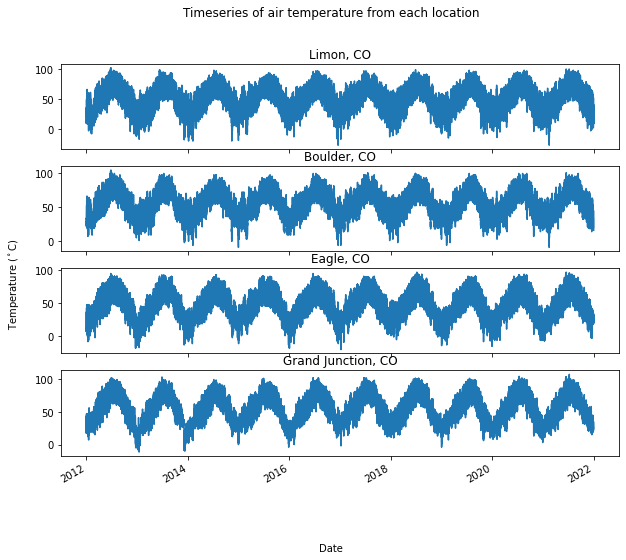

In [10]:
# graph timeseries subplots of temperature for the first 10 datapoint at all locations 
# this can be used to show that we looked at our data

fig, ax = plt.subplots(4, figsize = (10,8))
fig.suptitle("Timeseries of air temperature from each location")
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Temperature ($^\circ$C)', ha='center', va='center', rotation='vertical')

fig.autofmt_xdate()

# subplot 1: Limon
ax[0].plot(limonDF["datetime"],limonDF["drytemp_F"])
ax[0].set_title("Limon, CO")

# subplot 2: Boulder
ax[1].plot(boulderDF["datetime"], boulderDF["drytemp_F"])
ax[1].set_title("Boulder, CO")

# subplot 3: Eagle
ax[2].plot(eagleDF["datetime"], eagleDF["drytemp_F"])
ax[2].set_title("Eagle, CO")

# subplot 4: Grand Junction
ax[3].plot(grandJunctionDF["datetime"], grandJunctionDF["drytemp_F"])
ax[3].set_title("Grand Junction, CO")
fig.savefig("Look_at_data.jpg")

### Clustering and Plotting Functions

In [11]:
def select_time(df, hour):
    selectdf = df[df.hour==hour]
    return(selectdf)

In [12]:
included_cols = ["drytemp_F", 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph','wgust_mph']

In [13]:
def scale_and_convert_to_numpy(selectdf, included_cols):
    data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()
    scaled_data = whiten(data)
    return data, scaled_data # need to also return data

In [14]:
def cluster_data(NO_CLUSTERS, scaled_data):
    centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)
    idx, _ = vq(scaled_data,centroids)
    idx=idx+1
    return centroids, idx 

In [15]:
def seasonal_assignment_by_year(idx, city, cluster_label_list, NO_CLUSTERS):
    plt.figure(figsize = (10,6))
    plt.plot(idx[0:365],'.',label='2012');
    plt.plot(idx[365:365*2]+0.07,'.',label='2013');
    plt.plot(idx[365*2:365*3]+0.14,'.',label='2014');
    plt.plot(idx[365*3:365*4]+0.21,'.',label='2015');
    plt.plot(idx[365*4:365*5]+0.28,'.',label='2016');
    plt.plot(idx[365*5:365*6]+0.35,'.',label='2017');
    plt.plot(idx[365*6:365*7]+0.42,'.',label='2018');
    plt.plot(idx[365*7:365*8]+0.49,'.',label='2019');
    plt.plot(idx[365*8:365*9]+0.56,'.',label='2020');
    plt.plot(idx[365*9:365*10]+0.63,'.',label='2021');
    #plt.legend(loc='best');
    plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
    plt.yticks(ticks = np.arange(1.25,NO_CLUSTERS+1.25),labels=cluster_label_list);
    plt.xlabel('Day of the year')
    plt.title('Seasonal cycle of cluster assignment by Year for '+city);

In [16]:
def variable_scatter_plots(scaled_data, var1, var2, included_cols, NO_CLUSTERS, idx, centroids, data):
    vars2plot = [var1,var2]
    data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

    ## find the integer index of the variable to plot
    varidx2plot=np.zeros(2,dtype="int")
    for i in np.arange(0,2):
      #print(vars2plot[i])
      varidx2plot[i]=included_cols.index(vars2plot[i])
    #print(varidx2plot)

    ### Next plot these variables as the original valueswith colors to identify the associated cluster
    # (red=1, blue=2, grey=3, orange=4)
    cols = ['','red','blue','grey','orange']
    plt.figure(figsize=(8,5))
    plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
    for (ind,val) in enumerate(np.transpose(data2plot)):
        plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(vars2plot[0],fontsize=18);
    plt.ylabel(vars2plot[1],fontsize=18);
    plt.show()

    ### You can also plot these variables as scaled values with the cluster centers
    plt.figure(figsize=(8,5))
    plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
    plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
    plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('scaled '+vars2plot[0],fontsize=18);
    plt.ylabel('scaled '+vars2plot[1],fontsize=18);
    plt.show()

In [17]:
# processing work to do hist_type_1

def season_clustered(season_idx, seasonNum, idx, hour):
    ## find all of the days in the specified season, i.e., where season_idx= seasonNum
    seasonIdx=np.nonzero(np.where(season_idx==seasonNum,1,0))
    season=idx[seasonIdx]
    return season

In [18]:
# comparing month-based seasons to clustered seasons histogram

def hist_type_1(idx, season_idx, NO_CLUSTERS, cluster_label_list):
    delta= 1                               ## bin size
    minbin= 0.5                             ## minimum bin value
    maxbin= 5.5                              ## maximum bin value
    hist_bins = np.arange(minbin,maxbin,delta) ## bins
    #print(hist_bins) ## print your histograms to check them

    #### all data - plot the histogram
    h, mids = np.histogram(idx,bins=hist_bins);
    plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
    plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
    plt.ylabel('count')
    #plt.ylim(0,1000)
    plt.xticks(np.arange(1,NO_CLUSTERS+1),labels=cluster_label_list);
    plt.legend();
    plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

In [40]:
def hist_type_2(cluster_label_list, winter, spring, summer, fall):
    ## define bins for the histogram
    delta= 1                               ## bin size
    minbin= 0.5                             ## minimum bin value
    maxbin= 5.5                              ## maximum bin value
    hist_bins = np.arange(minbin,maxbin,delta) ## bins

    ### Show all seasons using subplots
    ### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
    cluster_label_list.insert(0,'')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle('k-means clustering results - all seasons',fontsize=20)
    fig.set_figheight(6)
    fig.set_figwidth(8)

    ymax=1000
    h, mids = np.histogram(winter,bins=hist_bins);
    ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
    ax1.set_title("winter");
    ax1.set_ylabel("count");
    ax1.set_ylim(0,ymax)
    
    h, mids = np.histogram(spring,bins=hist_bins);
    ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
    ax2.set_title("spring");
    ax2.set_ylim(0,ymax)
    
    h, mids = np.histogram(summer,bins=hist_bins);
    ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
    ax3.set_title("summer");
    ax3.set_xticklabels(cluster_label_list);
    ax3.set_ylabel("count");
    ax3.set_ylim(0,ymax)
    
    h, mids = np.histogram(fall,bins=hist_bins);
    ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
    ax4.set_title("fall");
    ax4.set_xticklabels(cluster_label_list);
    ax4.set_ylim(0,ymax)

    for ax in fig.get_axes():
        ax.label_outer()

In [20]:
# universal Variables
FOUR_CLUSTERS = 4
THREE_CLUSTERS = 3
TWO_CLUSTERS = 2
hour = 12
cluster_label_list = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

## Limon Cluster Analysis
- use **limonDF** at approximately noon
- start with 4 clusters, then 3 and 2
- if time, use **limonDF** at other times (early morning, midnight, afternoon)

### 4 Clusters

In [21]:
# Doing the K-means Clustering
limonClusterDF = select_time(limonDF, hour)
limonData, limonScaled = scale_and_convert_to_numpy(limonClusterDF,included_cols)
limonCentriods, limonIdx = cluster_data(FOUR_CLUSTERS,limonScaled) # this needs to be copied for different number of clusters

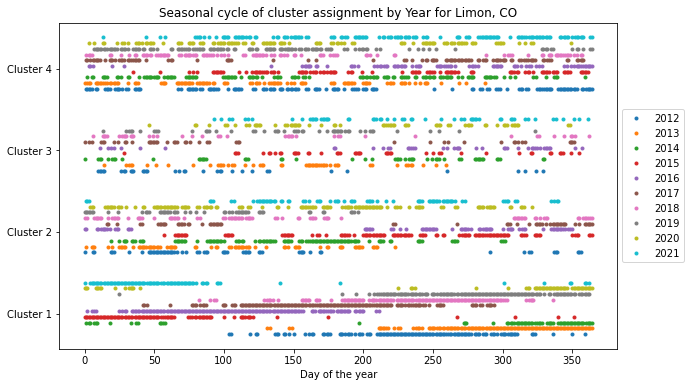

In [22]:
seasonal_assignment_by_year(limonIdx, "Limon, CO", cluster_label_list, FOUR_CLUSTERS)

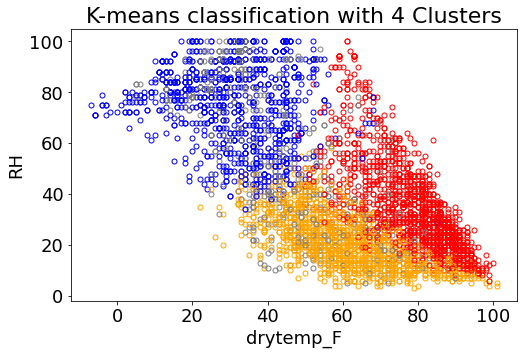

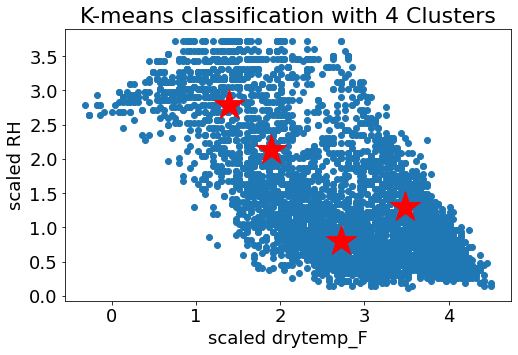

In [23]:
variable_scatter_plots(limonScaled, "drytemp_F","RH", included_cols, FOUR_CLUSTERS, limonIdx, limonCentriods, limonData)

In [24]:
# setting up for the month-based seasons vs. clustering seasons histogram
season_idx=limonDF['season'][limonDF.hour==hour].to_numpy()

winter = season_clustered(season_idx, 1, limonIdx, hour)
spring = season_clustered(season_idx,2, limonIdx, hour)
summer = season_clustered(season_idx, 3, limonIdx, hour)
fall = season_clustered(season_idx, 4, limonIdx, hour)

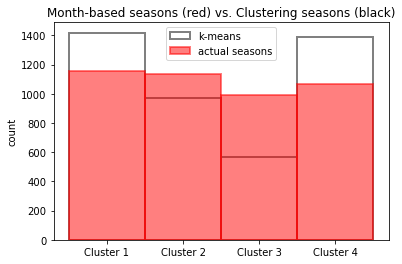

In [25]:
hist_type_1(limonIdx, season_idx, FOUR_CLUSTERS, cluster_label_list)

C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/2787971463.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(cluster_label_list);
C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/2787971463.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(cluster_label_list);


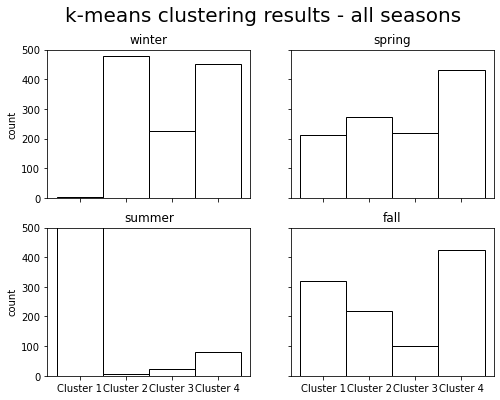

In [26]:
hist_type_2(cluster_label_list, winter, spring, summer, fall)
cluster_label_list.remove('') # this line is important!

In [27]:
# add cluster data to dataframe
limonClusterDF["clusters(4)"] = limonIdx

C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/1982073742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limonClusterDF["clusters(4)"] = limonIdx


### 3 Clusters

In [28]:
limonCentriods, limonIdx = cluster_data(THREE_CLUSTERS,limonScaled)

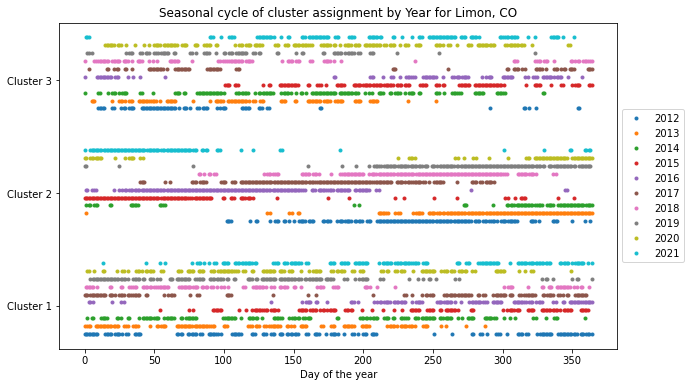

In [29]:
seasonal_assignment_by_year(limonIdx, "Limon, CO", cluster_label_list[0:3], THREE_CLUSTERS)

In [ ]:
variable_scatter_plots(limonScaled, "drytemp_F","RH", included_cols, THREE_CLUSTERS, limonIdx, limonCentriods, limonData)

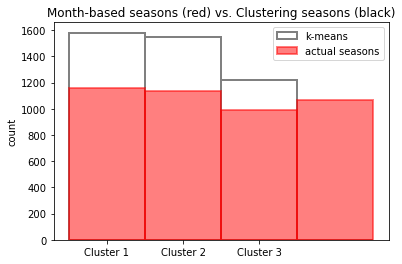

In [31]:
hist_type_1(limonIdx, season_idx, THREE_CLUSTERS, cluster_label_list[0:3])

### Two Clusters

In [55]:
limonCentriods, limonIdx = cluster_data(TWO_CLUSTERS,limonScaled)

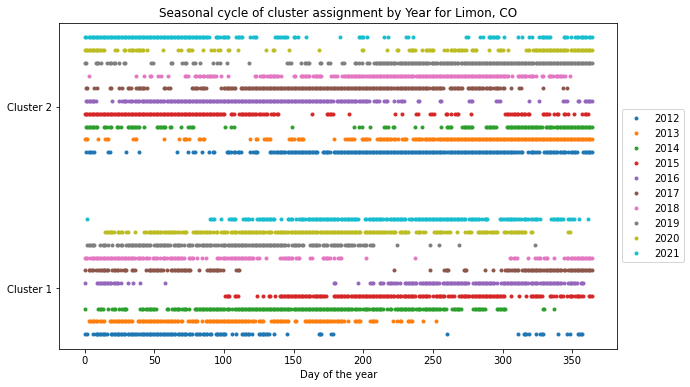

In [56]:
seasonal_assignment_by_year(limonIdx, "Limon, CO", cluster_label_list[0:2], TWO_CLUSTERS)

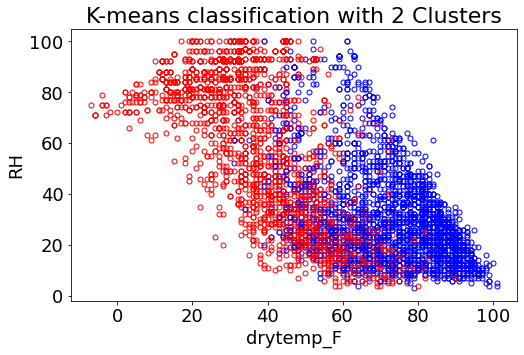

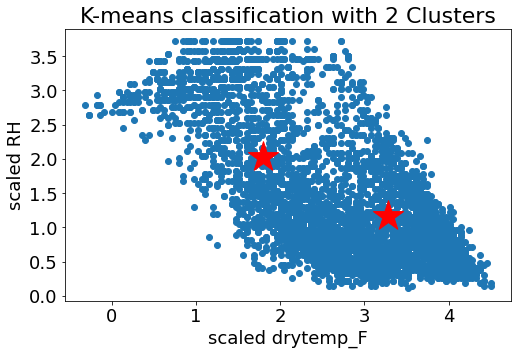

In [57]:
variable_scatter_plots(limonScaled, "drytemp_F","RH", included_cols, TWO_CLUSTERS, limonIdx, limonCentriods, limonData)

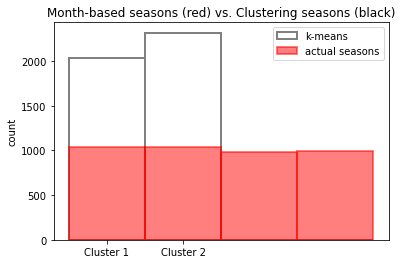

In [58]:
hist_type_1(limonIdx, season_idx, TWO_CLUSTERS, cluster_label_list[0:2])

## Boulder Cluster Analysis
- use **boulderDF** at approximately noon 
- start with 4 clusters, then 3 and 2
- if time, use **boulderDF** at other times (early morning, midnight, afternoon)

In [32]:
boulderClusterDF = select_time(boulderDF,hour)
boulderData, boulderScaled = scale_and_convert_to_numpy(boulderClusterDF,included_cols)
boulderCentriods, boulderIdx = cluster_data(FOUR_CLUSTERS,boulderScaled)

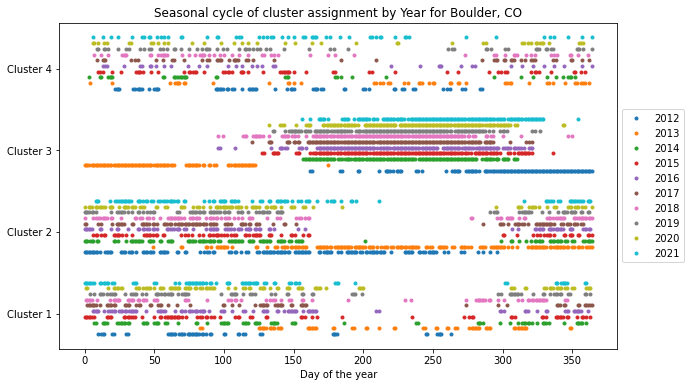

In [33]:
seasonal_assignment_by_year(boulderIdx, "Boulder, CO", cluster_label_list, FOUR_CLUSTERS)

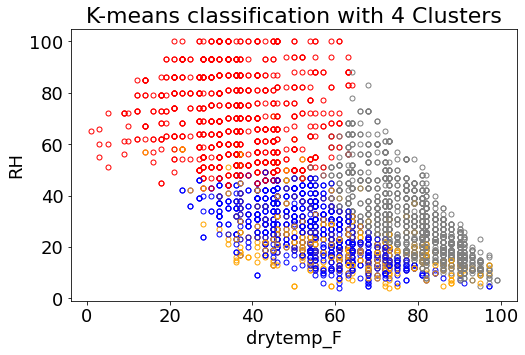

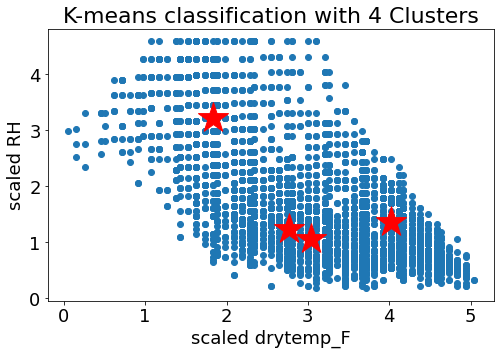

In [34]:
variable_scatter_plots(boulderScaled, "drytemp_F","RH", included_cols, FOUR_CLUSTERS, boulderIdx, boulderCentriods, boulderData)

In [35]:
season_idx=boulderDF['season'][boulderDF.hour==hour].to_numpy()

winter = season_clustered(season_idx, 1, boulderIdx, hour)
spring = season_clustered(season_idx,2, boulderIdx, hour)
summer = season_clustered(season_idx, 3, boulderIdx, hour)
fall = season_clustered(season_idx, 4, boulderIdx, hour)

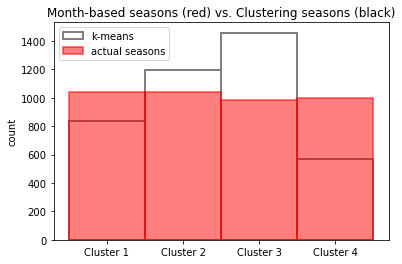

In [36]:
hist_type_1(boulderIdx, season_idx, FOUR_CLUSTERS, cluster_label_list)

C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/1078897810.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(cluster_label_list);
C:\Users\Sydney\AppData\Local\Temp/ipykernel_18552/1078897810.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(cluster_label_list);


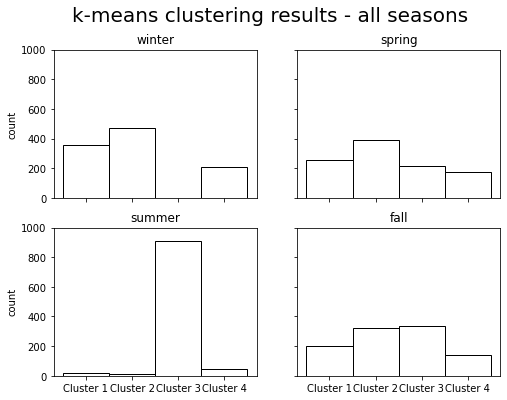

In [41]:
hist_type_2(cluster_label_list, winter, spring, summer, fall)
cluster_label_list.remove('') # this line is important!

### 3 Clusters

In [42]:
boulderCentriods, boulderIdx = cluster_data(THREE_CLUSTERS,boulderScaled)

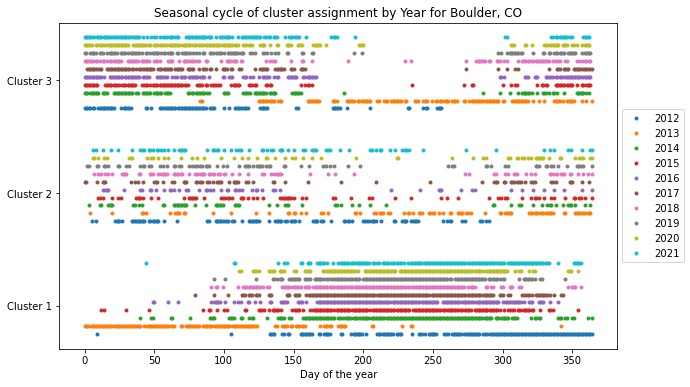

In [44]:
seasonal_assignment_by_year(boulderIdx, "Boulder, CO", cluster_label_list[0:3], THREE_CLUSTERS)

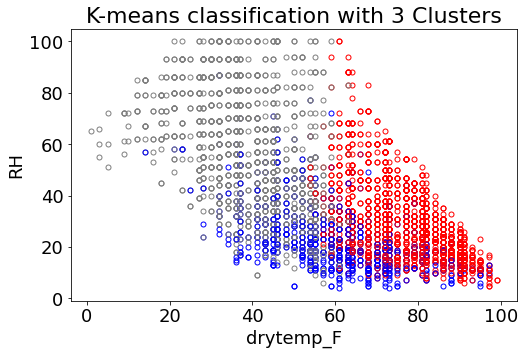

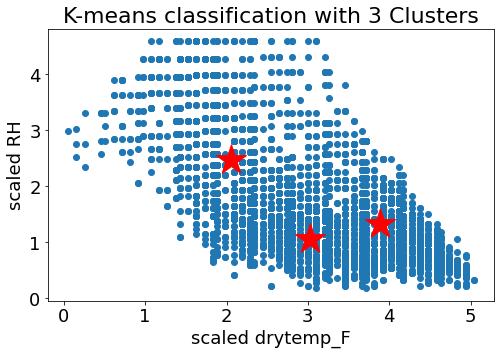

In [45]:
variable_scatter_plots(boulderScaled, "drytemp_F","RH", included_cols, THREE_CLUSTERS, boulderIdx, boulderCentriods, boulderData)

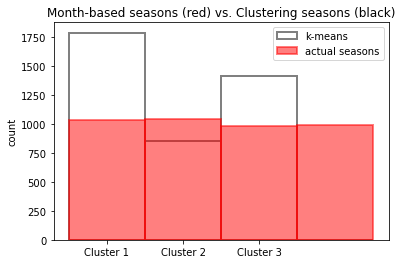

In [46]:
hist_type_1(boulderIdx, season_idx, THREE_CLUSTERS, cluster_label_list[0:3])

### 2 Clusters

In [51]:
boulderCentriods, boulderIdx = cluster_data(TWO_CLUSTERS,boulderScaled)

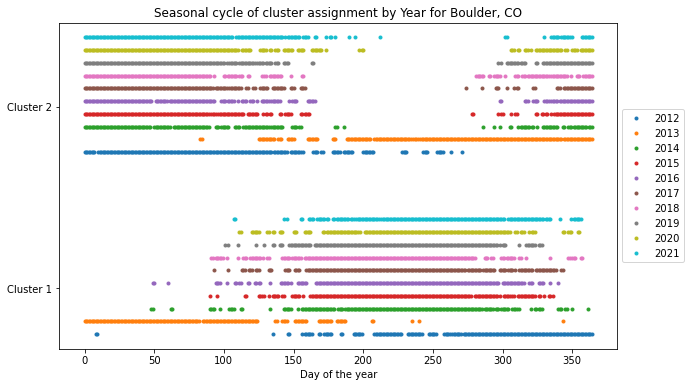

In [52]:
seasonal_assignment_by_year(boulderIdx, "Boulder, CO", cluster_label_list[0:2], TWO_CLUSTERS)

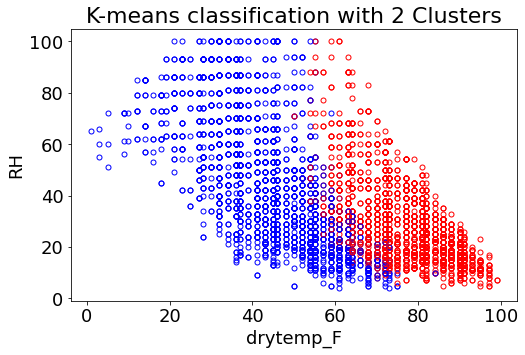

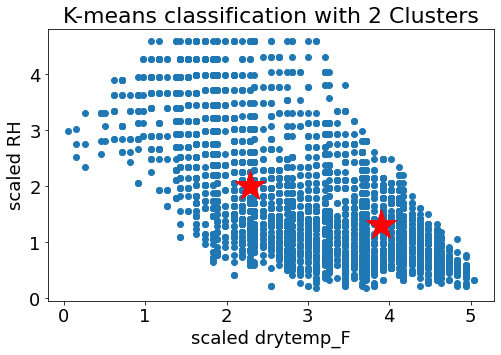

In [53]:
variable_scatter_plots(boulderScaled, "drytemp_F","RH", included_cols, TWO_CLUSTERS, boulderIdx, boulderCentriods, boulderData)

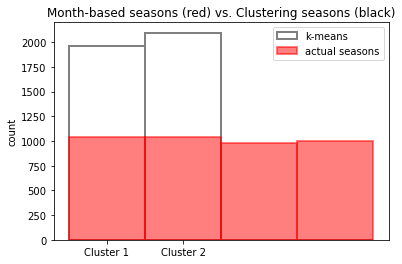

In [54]:
hist_type_1(boulderIdx, season_idx, TWO_CLUSTERS, cluster_label_list[0:2])